EE-311
======

Lab 4: Support Vector Machines (SVM)
------------------------------------

created by Natalie Bolón Brun and François Marelli on 11.03.2020

# Import libraries

In [195]:
from sklearn.datasets import load_iris, make_circles
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

# Load and prepare data

We will start with the same dataset as last week, using only the two first features. 

Since we want to explore the case of linear models, start start with checking if it is linearly separable on the scatter plot. 

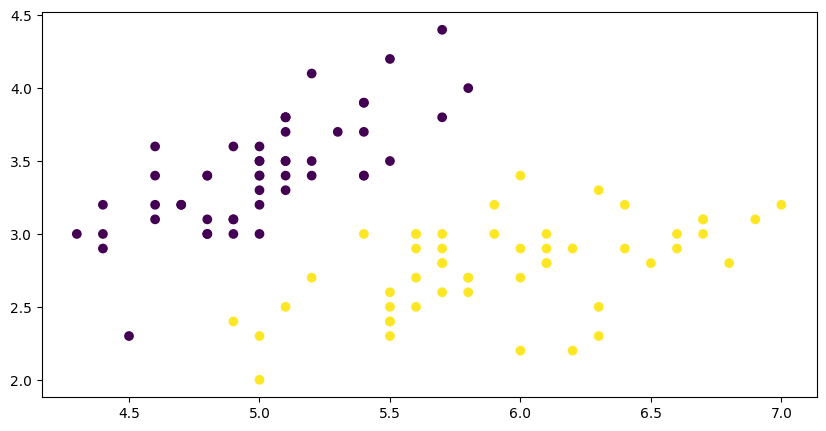

In [196]:
data_X, data_y = load_iris(return_X_y=True)

mask = (data_y == 0) | (data_y == 1)

data_X = data_X[mask]
data_y = data_y[mask]

data_X = data_X[:,0:2]

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.15, random_state=0)


plt.figure(figsize=(10,5))
plt.scatter(data_X[:,0], data_X[:,1], c=data_y)
plt.show()

## Compare SVM with logistic regression

Last week we used logistic regression for classification. This week we will investigate SVM. 

We will start by comparing their behavior for a SVM with hard margins.

1. What should we expect on our dataset? To have good separation. 
2. What is the C argument in the SVC? Why do we set it so high? The bigger C is, the more we want to maximize the distances but at the cost of worse behavior when the data isn't well separable. In our case the data looks very separable so we put C as big as possible.

In [197]:
# train logistic regression classifier
classifier_lr = LogisticRegression().fit(X_train, y_train)

# train SVM classifier
classifier_svm = SVC(kernel='linear', C=10000).fit(X_train, y_train)

# Compute the accuracy
accuracy_lr = classifier_lr.score(X_test, y_test)
accuracy_svm = classifier_svm.score(X_test, y_test)

print('Classification with Logistic Regression. Accuracy: {:.2f}%'.format(accuracy_lr * 100))
print('Classification with Support Vector Machine. Accuracy: {:.2f}%'.format(accuracy_svm * 100))

Classification with Logistic Regression. Accuracy: 100.00%
Classification with Support Vector Machine. Accuracy: 100.00%


## Compare decision boundaries

To check the difference between the two classifiers plot the decision boundary for each one. 

* Which classifier seems better? Why? The svm because it is more distant from other points

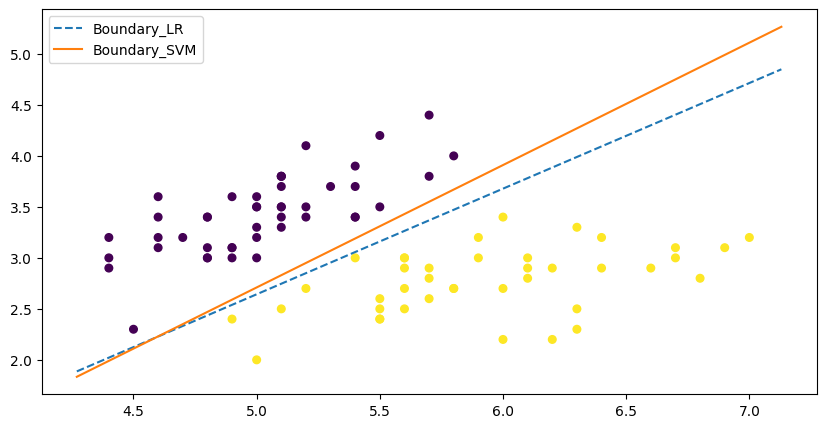

In [198]:
f, ax = plt.subplots(figsize=(10,5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30)

# get limits of the figure
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

x_plot = np.linspace(xlim[0], xlim[1], 30)


##################################################################
# Your code here

x=x_plot

y_lr = (-classifier_lr.coef_[0][0] * x - classifier_lr.intercept_[0]) / classifier_lr.coef_[0][1]

y_svm = (-classifier_svm.coef_[0][0] * x - classifier_svm.intercept_[0]) / classifier_svm.coef_[0][1]

##################################################################


ax.plot(x_plot, y_lr, '--', label='Boundary_LR')
ax.plot(x_plot, y_svm, '-', label='Boundary_SVM')

plt.legend()
plt.show()

## Compute Margins for each classifier

We have seen the decision boundaries are not equal. We can compute the margin of each classifier to evaluate numerically this difference. 

1. Which classifier has larger margin? The lr
2. Is the margin to all classes equal? for the SVM yes, for the LR no.

In [199]:
def distance(b, w, X):
    """
    Compute distance between a line and a point.
    The equation of the line given by: b + w[0] * X[:, 0] + w[1] * X[:, 1] = 0
    
    b: model intercept
    w: model coefficients
    X: data points (N, 2)
    
    Return: float, distance to hyperplane
    """
    
    #######################################################
    # Your code here
    return np.abs(b + w[0] * X[:, 0] + w[1] * X[:, 1]) / np.sqrt(w[0]**2 + w[1]**2)

    
    
    #######################################################


# first split the data by class
x_0 = data_X[data_y == 0]
x_1 = data_X[data_y == 1]


############################################################
# Code here to compute the margins for SVM and LR
distance_lr = distance(classifier_lr.intercept_[0], classifier_lr.coef_[0], data_X)
distance_svm = distance(classifier_svm.intercept_[0], classifier_svm.coef_[0], data_X)
print('Mean margin for Logistic Regression: {:.2f}'.format(np.mean(distance_lr)))
print('Mean margin for SVM: {:.2f}'.format(np.mean(distance_svm)))


Mean margin for Logistic Regression: 0.56
Mean margin for SVM: 0.57


## Visualize margins and support vectors

This function plots the decision hyperplane, the margin hyperplanes, and highlights the support vectors.

In [200]:
def visualize_margins(X_train, y_train, classifier_svm):

    f, ax = plt.subplots(figsize=(10,5))
    if X_train.shape[1] == 2:
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
    else:
        plt.scatter(X_train,X_train, c=y_train)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = classifier_svm.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(classifier_svm.support_vectors_[:, 0], classifier_svm.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

Let us use it to see the properties of our SVM

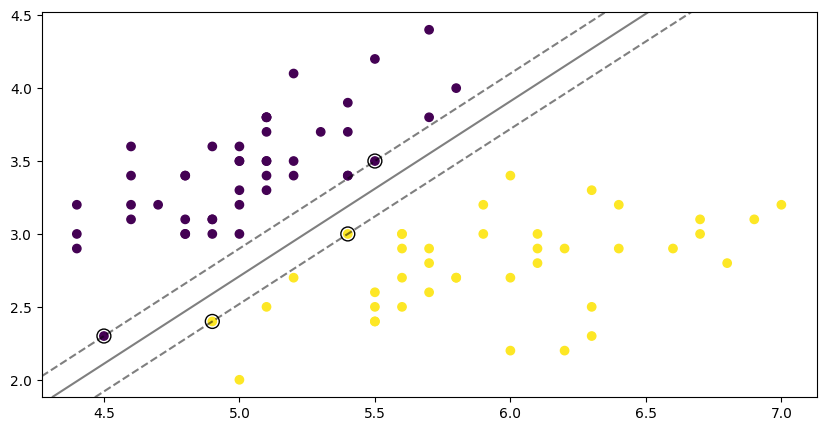

In [201]:
visualize_margins(X_train, y_train, classifier_svm)

# Soft-margin SVM

Manually generate a linearly separable dataset, then 
add noise with increasing amplitude until the dataset is not perfectly 
separable anymore.

Let's explore how we can use SVM with soft-margins and how the penalty term affects our classifier.

Modify the variance (sigma) of each class to see how the data goes from linearly separable to not separable anymore. 

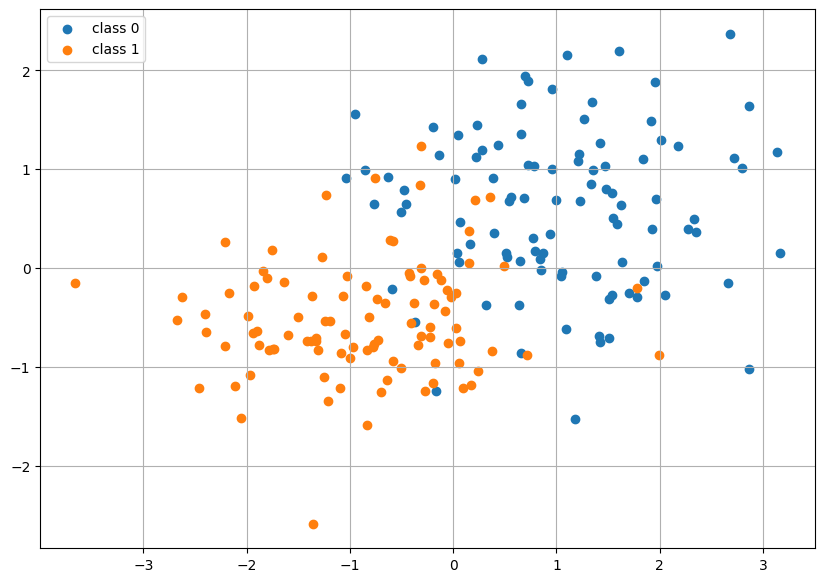

In [202]:
num_points = 100


plt.figure(figsize=(10, 7))

##################################################################
# Increase these variances until the datasets become non separable

rg = np.random.default_rng(0)
sigma_0 = 0.9
sigma_1 = 0.9


# We define the datasets by their mean and covariance
cov_0 = [[sigma_0, 0.05], [0.05, 0.8]]
cov_1 = [[sigma_1, 0.05], [0.05, 0.3]]
mu_0 = [1, 0.5]
mu_1 = [-1, -0.5]

X_class0 = rg.multivariate_normal(mu_0, cov_0, num_points)
X_class1 = rg.multivariate_normal(mu_1, cov_1, num_points)

plt.scatter(X_class0[:,0],X_class0[:,1],label='class 0')
plt.scatter(X_class1[:,0],X_class1[:,1],label='class 1')
plt.grid()
plt.legend()
    
plt.show()

For the non-separable case, train a classifier varying the penalty term.

Show the evolution of the decision hyperplane and the margins using the function *visualize_margins*.

To modify the penalty term you can check the documentation of the function:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    
1. What do you notice about the margins? When C is small, the SVM won't necessarily take the smallest support vector, when C is bigger it will. When we increase the noise though, the svm has a hard time finding the closest support vectors.
2. How do you explain this behaviour? This is because noise makes things weird.

Classification with Logistic Regression. Accuracy: 90.00%
Classification with Support Vector Machine. Accuracy: 90.00%


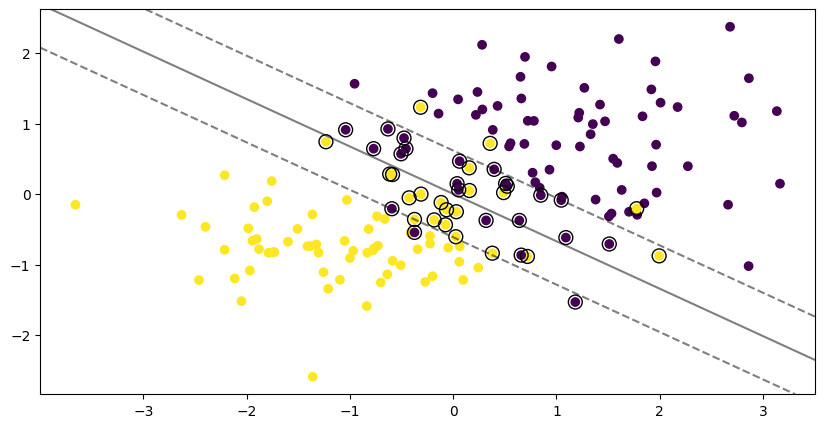

In [203]:
# Preparing the dataset for training
X = np.concatenate([X_class0, X_class1])
y = np.concatenate([np.zeros(num_points), np.ones(num_points)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#######################################################
# Time to code!
classifier_svm = SVC(kernel='linear', C=1).fit(X_train, y_train)
classifier_lr = LogisticRegression().fit(X_train, y_train)

accuracy_lr = classifier_lr.score(X_test, y_test)
accuracy_svm = classifier_svm.score(X_test, y_test)

print('Classification with Logistic Regression. Accuracy: {:.2f}%'.format(accuracy_lr * 100))
print('Classification with Support Vector Machine. Accuracy: {:.2f}%'.format(accuracy_svm * 100))

visualize_margins(X_train, y_train, classifier_svm)

# Non-linearly separable data

In this part we will use a n non-linearly separable dataset and very¡ify the poor performance of SVM. 

Nevertheless, the data may be linearly separable in an transformed space. Let's see how can we solve it.

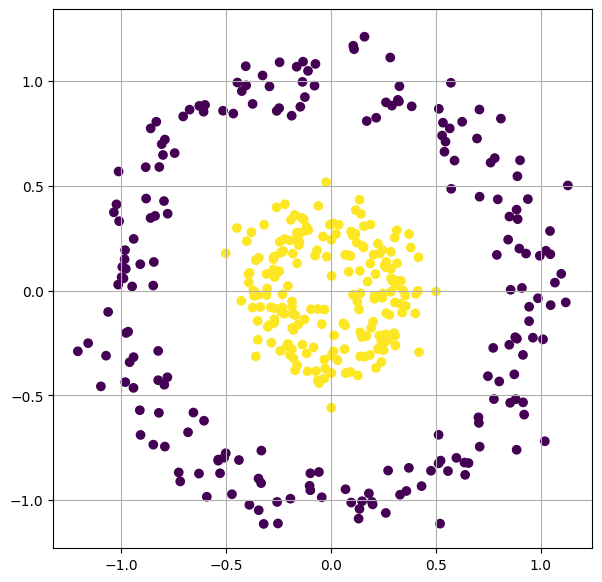

In [204]:
X, y = make_circles(n_samples=400, noise=0.1, factor=0.3, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

plt.figure(figsize=(7, 7))
plt.scatter(X[:,0],X[:,1],c=y )
plt.axis('square')
plt.grid()
plt.show()

Given the following data, answer the following:

1. Is it separable? yes
2. Is it linearly separable? no
3. Is a linear SVM going to perform well? hell no

Train a SVM linear classifier. 

Does it work? What's the accuracy? No, the accuracy is 47.5 %

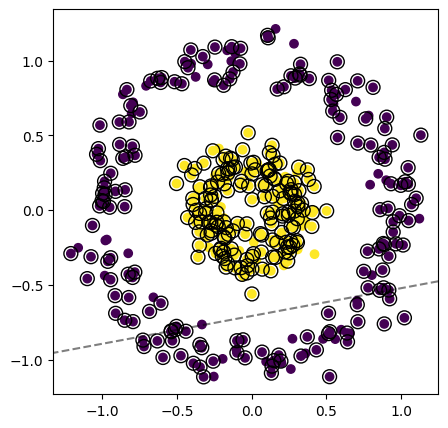

Classification with Support Vector Machine. Accuracy: 47.50%


In [205]:
clr = SVC(kernel='linear')


#######################################################
# Your code here
clr.fit(X_train, y_train)


#######################################################


visualize_margins(X, y, clr)
plt.axis('square')
plt.show()

score = clr.score(X_test, y_test)
print('Classification with Support Vector Machine. Accuracy: {:.2f}%'.format(score * 100))

Apply a transformation to X_train so that the data becomes linearly separable, and plot it.

Then train a SVM classifier with linear kernel, and plot its boundary and margins.

What's the accuracy on the transformed dataset? it's 100%

*Hint: think about the equations of a circle for the transformation*

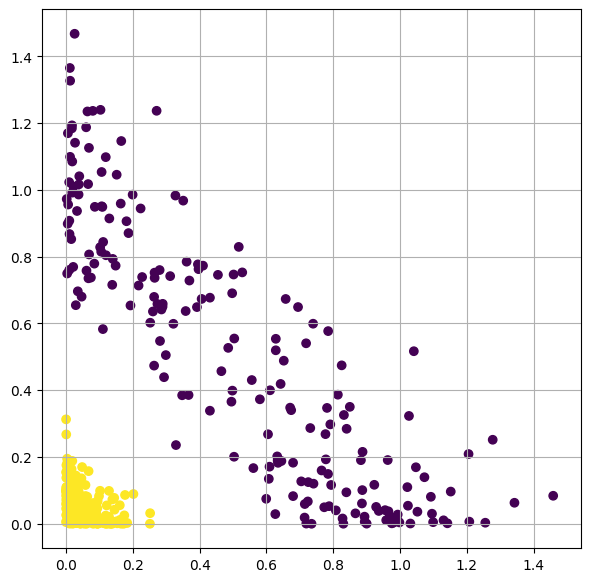

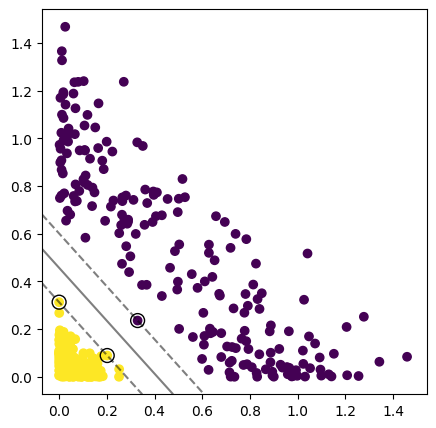

Classification with Support Vector Machine. Accuracy: 100.00%


In [206]:
clr = SVC(kernel='linear', C=1e6)


################################################################################################
# Your code here: transform the dataset, plot it then train a SVM, plot its accuracy and margins

X=X**2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

plt.figure(figsize=(7, 7))
plt.scatter(X[:,0],X[:,1],c=y )
plt.axis('square')
plt.grid()
plt.show()

clr.fit(X_train, y_train)
visualize_margins(X, y, clr)
plt.axis('square')
plt.show()

score = clr.score(X_test, y_test)
print('Classification with Support Vector Machine. Accuracy: {:.2f}%'.format(score * 100))


## The kernel trick

Instead of transforming the state, we can use an appropriate kernel to train the SVM.

The kernel redefines the notion of distance with respect to the SVM boundary. It is equivalent to transforming the space and then computing distances to a hyperplane, but requires less complex computations.

A very commonly used kernel is the RBF (radial basis function). It corresponds to a transformation to a space of infinite dimension.

Train a SVM with RBF kernel on the non-transformed data and check its accuracy.

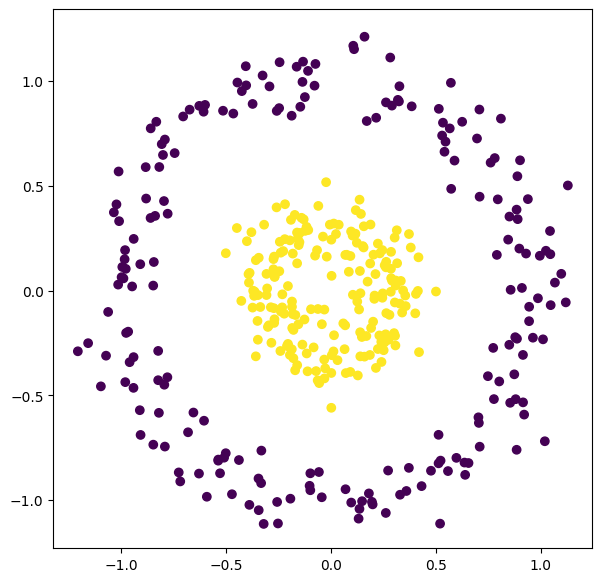

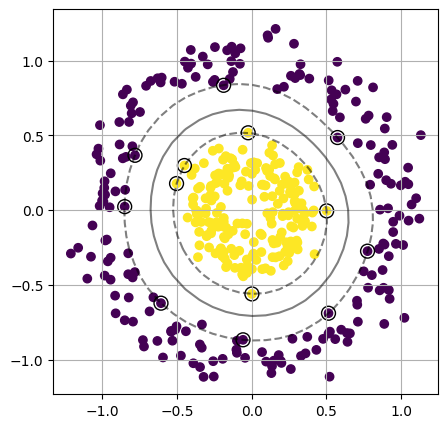

In [207]:
clr = SVC(kernel='rbf', C=1e6)


#########################################
# Train the model and print the accuracy
X, y = make_circles(n_samples=400, noise=0.1, factor=0.3, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

plt.figure(figsize=(7, 7))
plt.scatter(X[:,0],X[:,1],c=y )
plt.axis('square')

clr.fit(X_train, y_train)




#########################################


visualize_margins(X, y, clr)
plt.axis('square')
plt.grid()
plt.show()

## Bonus: outlier detection

These plots show some of the datasets used to test outlier detection. The outliers are highlighted in purple.

An outlier is a data point with an extreme value that diverges from the rest of the dataset. It can sometimes be due to experimental errors, and can then decrease the performance of models as they try to model extreme values that should not be there in practice. It can therefore be useful to be able to detect outliers in a dataset to deal with them appropriately.

It must be noted that outliers do not always represent errors, sometimes they can be due to very rare but genuine events. Therefore discarding outliers must only be done after a precise analysis and a serious reflexion.

Implement a function to detect the outlier automatically. Think about what characterises an outlier!

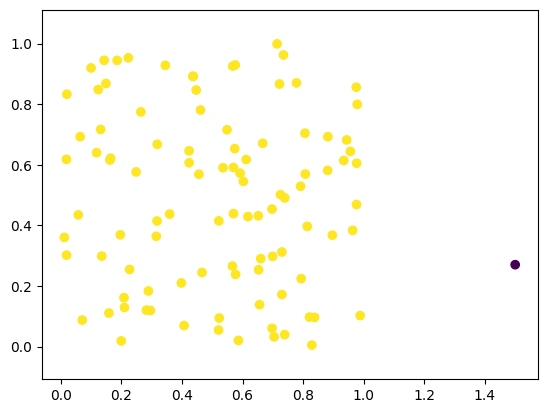

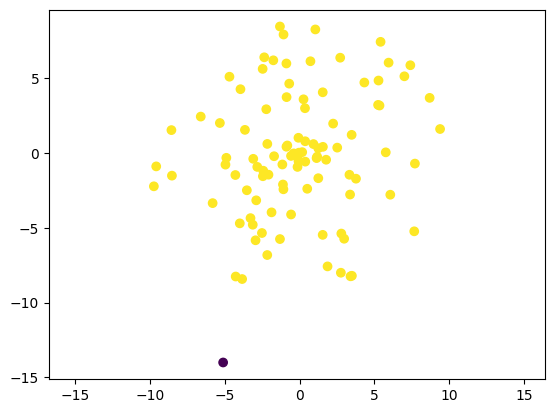

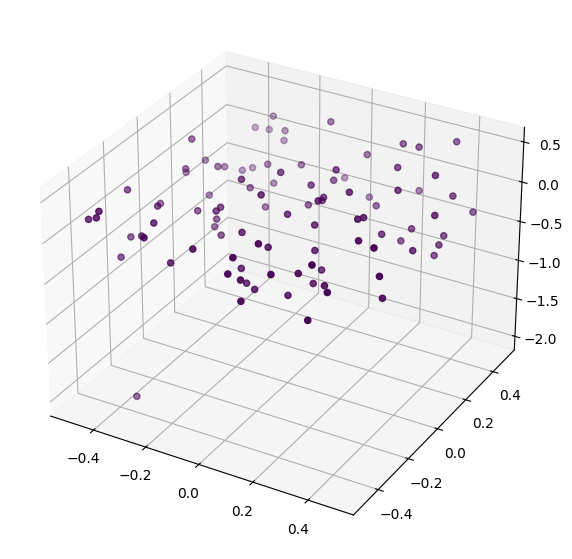

In [212]:
outliers = np.load('outliers.npz')
indexes = outliers['index']


def detect_outlier(X):
    '''
    Detect the outlier in dataset X and return its position (0-based indexing)
    
    X: array (N, M) with N being the number of points and M the number of features
    
    Return: int, the position index of the outlier in the dataset
    '''
    
    ##############################################
    # Code here
    y = np.ones(len(X))
    y [-1:] = 0

    clf = SVC(kernel='linear', C=1)
    clf.fit(X, y)
    distances = clf.decision_function(X)

    return np.argmax(distances)
    #############################################


outlier = outliers['0']
idx = indexes[0]
color = np.ones(outlier.shape[0])
color[idx] = 0
plt.scatter(outlier[:, 0], outlier[:, 1], c=color)
plt.axis('equal')
plt.show()


outlier = outliers['1']
idx = detect_outlier(outlier)
color = np.ones(outlier.shape[0])
if idx is not None:
    color[idx] = 0
plt.scatter(outlier[:, 0], outlier[:, 1], c=color)
plt.axis('equal')
plt.show()


outlier = outliers['2']
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

color = np.ones(outlier.shape[0])
idx = detect_outlier(outlier)
if idx is not None:
    color[idx] = 0
ax.scatter(outlier[:,0], outlier[:,1], outlier[:,2], c=color)
plt.show()